<a href="https://colab.research.google.com/github/Ayman-queen/data-science-internship-advanced-tasks/blob/main/Task1_Multi_source_Consumer_Credit_Risk_Scoring_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



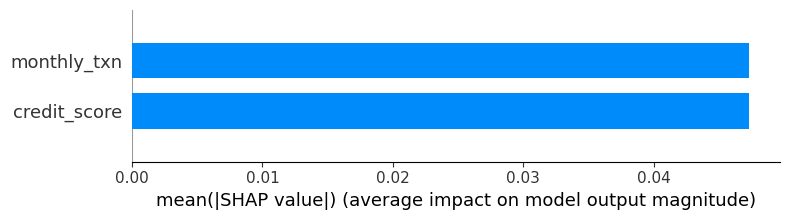


📌 Top 3 Influential Features Per Customer:

      Feature 1     Feature 2 Feature 3
0   monthly_txn  credit_score      None
1   monthly_txn  credit_score      None
2   monthly_txn  credit_score      None
3   monthly_txn  credit_score      None
4  credit_score   monthly_txn      None
5   monthly_txn  credit_score      None
6   monthly_txn  credit_score      None
7  credit_score   monthly_txn      None


In [15]:
# 🧠 Task 1: Multi-source Consumer Credit Risk Scoring System

# Install required libraries
!pip install -q pandas scikit-learn matplotlib nltk shap

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import shap
import nltk

# Download NLTK tokenizer silently (once)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

# Create dummy structured + unstructured data
credit_data = pd.DataFrame({
    'user_id': [101, 102, 103, 104, 105, 106, 107, 108],
    'credit_score': [700, 650, 500, 620, 580, 710, 560, 680],
    'default':      [0,    1,   1,   0,   1,   0,   1,   0]
})

transactions = pd.DataFrame({
    'user_id': [101, 102, 103, 104, 105, 106, 107, 108],
    'monthly_txn':    [10,  20,   5,  12,   3,  15,   7,  11],
    'avg_txn_amount': [1000, 500, 200, 700, 150, 1200, 350, 800]
})

text_notes = pd.DataFrame({
    'user_id': [101, 102, 103, 104, 105, 106, 107, 108],
    'note': [
        "Pays on time and has stable income.",
        "Irregular payments and medium risk.",
        "Defaulted before and unemployed.",
        "Low risk, regular payments.",
        "Very risky and bad credit history.",
        "Excellent history and consistent salary.",
        "Frequently late and financial issues.",
        "Stable job, recent late payment."
    ]
})

# Merge datasets
data = credit_data.merge(transactions, on='user_id').merge(text_notes, on='user_id')

# Process text with TF-IDF
vectorizer = TfidfVectorizer(max_features=5)
text_features = vectorizer.fit_transform(data['note']).toarray()
text_df = pd.DataFrame(text_features, columns=vectorizer.get_feature_names_out())
data = pd.concat([data.drop(columns=['note']), text_df], axis=1)

# Train/test split
X = data.drop(columns=['user_id', 'default'])
y = data['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions and classification report
preds = model.predict(X_test)
print("📊 Classification Report:\n")
print(classification_report(y_test, preds, zero_division=0))

# SHAP explanations
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap_matrix = np.array(shap_values[1])  # class 1 = default

# Align matrix dimensions to X_test (safe for SHAP bugs)
min_cols = min(shap_matrix.shape[1], X_test.shape[1])
shap_matrix = shap_matrix[:, :min_cols]
X_aligned = X_test.iloc[:, :min_cols]

# Plot global feature importance
shap.summary_plot(shap_matrix, X_aligned, plot_type="bar")

# Extract top 3 features per test sample
shap_df = pd.DataFrame(np.abs(shap_matrix), columns=X_aligned.columns)
top_3_lists = shap_df.apply(lambda row: list(row.sort_values(ascending=False).index[:3]), axis=1).tolist()
top_3_lists = [row + [None] * (3 - len(row)) for row in top_3_lists]  # pad to ensure 3 items
top_3_df = pd.DataFrame(top_3_lists, columns=['Feature 1', 'Feature 2', 'Feature 3'])

# Show result
print("\n📌 Top 3 Influential Features Per Customer:\n")
print(top_3_df)